<a href="https://colab.research.google.com/github/akitim/Ligand_activity_prediction_GlobalAI2022/blob/main/ligand_activity_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт библиотек

In [20]:
!python -m pip install rdkit-pypi

In [21]:
!pip install catboost

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Descriptors import MolWt

from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

## Функции

In [23]:
def get_submission_file(clf, data):
    
    X_test = data[data['is_test']].\
        drop(['is_test', 'smiles', 'active'], axis=1)

    submission = data[data['is_test']].\
        drop(['is_test', 'active'], axis=1).copy()
    submission['Active'] = clf.predict(X_test)
    submission.columns = ['Smiles', 'Active']

    submission.to_csv('submission.csv')
    return submission

## Загружаем данные:

In [221]:
train_path = 'https://raw.githubusercontent.com/akitim/datasets/main/ligand_activity_prediction/train.csv'
test_path = 'https://raw.githubusercontent.com/akitim/datasets/main/ligand_activity_prediction/test.csv'

train = pd.read_csv(train_path)
# train = pd.read_csv('/content/train.csv')
test = pd.read_csv(test_path)
# test = pd.read_csv('/content/test.csv')

train.sample(5)

,Unnamed: 0,Smiles,Active
4089,4089,Br.CN1[C@H]2C[C@H](OC(=O)[C@H](CO)c3ccccc3)C[C...,False
1124,1124,CN1C2CCC1CC(OC(c1ccc(F)cc1)c1ccc(F)cc1)C2.Cl,False
4080,4080,O=c1[nH]c(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1...,False
3085,3085,CNC(=O)[C@H]1O[C@@H](n2cnc3c(NCc4cccc(I)c4)ncn...,False
576,576,O=c1c(-c2ccc(O)cc2)coc2cc(O[C@@H]3O[C@H](CO)[C...,False


In [222]:
train = train.loc[:, ['Smiles', 'Active']]
train.columns = ['smiles', 'active']
train['is_test'] = False
# train['active'] = train['active'].astype('int32')

test = test.loc[:, ['Smiles']]
test['active'] = None #pd.NA().nan
test.columns = ['smiles', 'active']
test['is_test'] = True

data = pd.concat([train, test]).reset_index(drop=True)

In [26]:
data.sample(5)

,smiles,active,is_test
1881,C=C(C)[C@H]1CN[C@H](C(=O)O)[C@H]1CC(=O)O,0.0,False
6460,CN(C)CCOC1=Cc2ccccc2Sc2ccc(Cl)cc21,NaN,True
1286,O=S(=O)(NCC1CC1)c1ccc(Nc2nccc(N3CCCc4cc(O)ccc4...,0.0,False
4561,NC(=O)CN1CC[C@@H](NC(=O)[C@@H]2CCCN2)C1=O,0.0,False
6101,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(N)=O)c1...,NaN,True


In [83]:
train.shape, test.shape

((5557, 3), (1614, 3))

In [84]:
active_ind = train.groupby('active').groups[1]
not_active_ind = train.groupby('active').groups[0]
print(f"Active: {active_ind.size}\n\
Not active: {not_active_ind.size}")

Active: 206
Not active: 5351


## Модель 0 (random baseline)

In [30]:
# submission = test.copy()
# submission['Active'] = (np.random.rand(test.shape[0]) <= 206 / 5351)
# #(np.random.rand(test.shape[0]) <= 206 / 5351) #.astype('int32')
# test.loc[test['Active'], 'Active'].count() / test.shape[0]
# submission.to_csv('submission.csv')


## Предобработка

In [244]:
# import re
def replace_from_ls(str_, ls):
    new_str_ = str_
    for s in ls:
        new_str_ = new_str_.replace(s, '')
    return new_str_

salt_ion_list = ['.[Na+]', '.[K+]', '.[Li+]', '.[Ca+2]', '.[Ba+2]', '.[Sr2+]',
                 '.[I-]', '.[Cl-]', '.[Mg+2]', '.[Zn+2]', '.[N+]([O-])[O-]' ]

salt_ion_mask = data['smiles'].apply(lambda m: any(a in m for a in salt_ion_list))
data.loc[salt_ion_mask, 'smiles'] = \
    data.loc[salt_ion_mask, 'smiles']\
    .apply(lambda s: replace_from_ls(s, salt_ion_list))
data.loc[salt_ion_mask, 'smiles']
data.loc[data['smiles'].apply(lambda m: any(a in m for a in ['.Br', 'Br.','.Cl', 'Cl.', '.I', 'I.']))]
# data.loc[data['smiles'].apply(lambda m: all(a not in m for a in ['c', 'C'])), ['smiles', 'active']]
# salt_ion_list = ['].[']

,smiles,active,is_test


## Генерация новых признаков

In [108]:
def num_of_(df, atom) -> pd.DataFrame:
    df_ = df.copy()
    df_[atom] = df_['smiles'].apply(lambda smpl: smpl.count(atom))
    return df_    

data['MW'] = data['smiles'].apply(lambda x:
                                  np.round(MolWt(Chem.MolFromSmiles(x)), 1))

atoms = ['C', 'c', 'O', 'o', 'N', 'N+', 'n', 'P', 'p',
         'S', 's', 'Cl', 'Br', 'F', '(']
for a in atoms:
    data = num_of_(data, a)

In [10]:
RND_SEED = 42

# стандартизируем ВСЕ данные, опираясь на параметры тренировочной выборки
# меняем data!!!

std_scaler = StandardScaler()
std_scaler.fit(data[~data['is_test']]
               .drop(['is_test', 'smiles', 'active'], axis=1))

X_total = data.drop(['is_test', 'smiles', 'active'], axis=1)
X_total.loc[:,:] = std_scaler.transform(X_total)
data.loc[:, ~data.columns.isin(['is_test', 'smiles', 'active'])] = X_total

# разбиваем датасет на тренировку и валидацию
X = data[~data['is_test']].drop(['is_test', 'smiles', 'active'], axis=1)
y = data.loc[~data['is_test'], 'active']

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=RND_SEED)

## Логрегрессия и случайный лес

In [111]:
RND_SEED = 42

lrgr = LogisticRegression(random_state=RND_SEED,
                          n_jobs=-1, 
                          class_weight='balanced',
                          max_iter=500)
lrgr.fit(X_train, y_train)
y_pred_lrgr = lrgr.predict(X_val)

# y_pred_lrgr = ~y_pred_lrgr.astype(bool)
f1_lrgr = f1_score(y_val, y_pred_lrgr)

rfc = RandomForestClassifier(n_estimators=1000, criterion="entropy",
                             max_depth=60, min_samples_leaf=4,
                             min_samples_split=2,
                             max_features=None, bootstrap=True,
                             n_jobs=-1, random_state=RND_SEED,
                             class_weight='balanced')
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_val)
# y_pred_rfc = ~y_pred_rfc.astype(bool)

f1_rfc = f1_score(y_val, y_pred_rfc)
f1_lrgr, f1_rfc

(0.0990990990990991, 0.1111111111111111)

## Submission LogRegression

In [ ]:
submission = test.drop(['is_test', 'active'], axis=1).copy()

X_test = data[data['is_test'] == 1].drop(['is_test', 'smiles', 'active'], axis=1)
y_pred_test = lrgr.predict(X_test)

submission['Active'] = y_pred_test
submission.columns = ['Smiles', 'Active']
submission

# #(np.random.rand(test.shape[0]) <= 206 / 5351) #.astype('int32')
# test.loc[test['Active'], 'Active'].count() / test.shape[0]
# submission.to_csv('submission.csv')

,Smiles,Active
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,False
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,True
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,False
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,False
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,True
...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,True
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,True
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,False
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,True


## Логрегрессия с кросс-валидацией

In [11]:
lrgr_cv = LogisticRegressionCV(Cs=10,
                               cv=5, # cv=int - Stratified Cross-Validation w/10 folds
                               scoring='f1',
                               solver='liblinear',
                               penalty='l2',
                               max_iter=500,
                               class_weight='balanced',
                               random_state=RND_SEED, 
                            #    l1_ratios=np.arange(0, 1.2, 0.3)
)
lrgr_cv.fit(X, y)


LogisticRegressionCV(class_weight='balanced', cv=5, max_iter=500,
                     random_state=42, scoring='f1', solver='liblinear')

Max F1 = 0.11204538764574293


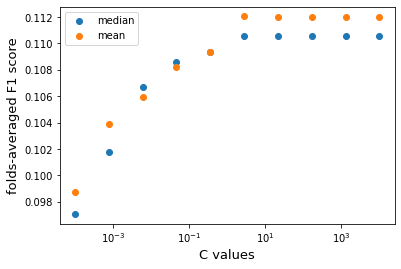

In [12]:
lrgr_cv.scores_[True].shape
lrgr_cv.get_params()

# print(lrgr_cv.Cs_)
# print(lrgr_cv.scores_[True].mean(axis=0))

plt.scatter(lrgr_cv.Cs_, np.median(lrgr_cv.scores_[True], axis=0));
plt.scatter(lrgr_cv.Cs_, np.mean(lrgr_cv.scores_[True], axis=0));
plt.xlabel('C values', fontsize=13)
plt.ylabel('folds-averaged F1 score', fontsize=13)
plt.xscale('log');
plt.legend(['median', 'mean'], loc='best');

print( f'Max F1 = {np.mean(lrgr_cv.scores_[True], axis=0).max()}')

##Catboost

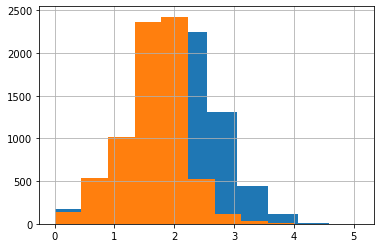

In [136]:
data.C.apply(lambda a: np.log1p(a)).hist();
data['('].apply(lambda a: np.log1p(a)).hist();

In [19]:
from catboost import CatBoostClassifier, Pool, FeaturesData

# разбиваем датасет на тренировку и валидацию
X_cb = data[~data['is_test']].drop(['is_test', 'active'], axis=1)
y_cb = data.loc[~data['is_test'], 'active']

X_cb_train, X_cb_val, y_cb_train, y_cb_val = train_test_split(
    X_cb, y_cb, test_size=0.2, random_state=RND_SEED
)

X_cb_train_fd= Pool(FeaturesData(
    num_feature_data = X_cb_train['MW'].values.reshape(-1, 1).astype(np.float32),
    cat_feature_data = X_cb_train.drop(['MW', 'smiles'], axis=1).values,
    num_feature_names = ['MW'],
    cat_feature_names = X_cb_train.drop(['MW', 'smiles'], axis=1).values.astype(object)
))

X_cb_val_pool = Pool(FeaturesData(
    num_feature_data = X_cb_val['MW'].values.reshape(-1, 1).astype(np.float32),
    cat_feature_data = X_cb_val.drop(['MW', 'smiles'], axis=1).values,
    num_feature_names = ['MW'],
    cat_feature_names = X_cb_val.drop(['MW', 'smiles'], axis=1).values.astype(object)
))

# X_cb_train_pool = 

CatBoostError: ignored

In [18]:
X_cb_val.drop(['MW', 'smiles'], axis=1).values.astype(object)

array([[0.33943086104088804, 1.2952135849723885, -1.0273772337303795,
        ..., -0.15756868949273237, -0.32357945632530166,
        -0.48138942991346767],
       [-0.16840175518155656, -0.6144024290959913, -0.09206673441194588,
        ..., -0.15756868949273237, -0.32357945632530166,
        -0.20634510932647002],
       [-0.16840175518155656, -0.6144024290959913, -0.7156070672909017,
        ..., 8.064114010142138, -0.32357945632530166,
        -0.48138942991346767],
       ...,
       [1.2281379394301661, -1.569210436130181, 0.5314735984670099, ...,
        -0.15756868949273237, -0.32357945632530166, 0.8938321730215206],
       [0.5933471691521103, -0.6144024290959913, 1.1550139313459657, ...,
        -0.15756868949273237, -0.32357945632530166, 1.443920814195516],
       [-0.54927621734839, -0.9326717647740546, 0.5314735984670099, ...,
        -0.15756868949273237, 0.5980663862168313, -0.20634510932647002]],
      dtype=object)

In [125]:
X_cb = data[~data['is_test']].drop(['is_test', 'active'], axis=1)

str

---
---
---
ИДЕИ
---
---

### Визуализация молекулы

In [ ]:
# 616                        O1[As]2O[As]3O[As]1O[As](O2)O3
# 1144                                        O=N[O-].[Na+]
# 1172    O=[Mg].O=[Mg].O=[Mg].O=[Si]=O.O=[Si]=O.O=[Si]=...
# 2569                                            [I-].[K+]
# 2858                         O=P([O-])([O-])F.[Na+].[Na+]
# 6264                                          NS(N)(=O)=O

# 616          O1[As]2O[As]3O[As]1O[As](O2)O3
# 915          CC(=O)Nc1cc([As](=O)(O)O)ccc1O
# 5864     O=[N+]([O-])c1ccc([As](=O)(O)O)cc1
# 6562    O=[N+]([O-])c1cc([As](=O)(O)O)ccc1O
# 6761                Nc1ccc([As](=O)(O)O)cc1

Cl.Cl.Fc1ccc(C(OCCN2CCN(C/C=C/c3ccccc3)CC2)c2ccc(F)cc2)cc1
Unknown


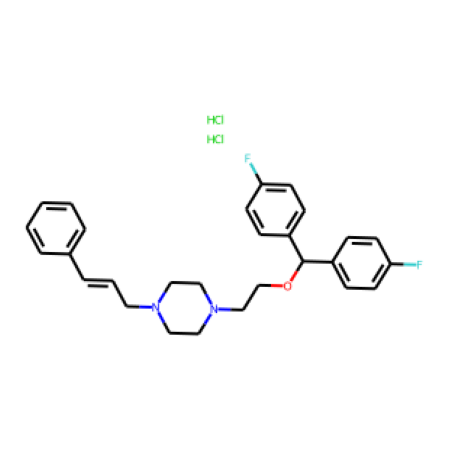

In [240]:
# smpl = train['smiles'][134]
smpl_ind = 6081
smpl = data.loc[smpl_ind, 'smiles']
# smpl = 'C(-c6cnc7ccccc7c6)'
if_active = 'Active' if data.loc[smpl_ind, 'active'] \
                    else ('Not active' if smpl_ind < 5556 else 'Unknown')

mol = Chem.MolFromSmiles(smpl)
im = Chem.Draw.MolToImage(mol)
print(f'{smpl}\n{if_active}')
plt.figure(figsize = (8, 8))
axs = plt.axes(frameon=True)
axs.imshow(im)
axs.axis('off');

### Визуализируем активные молекулы:

In [29]:
# smiles_active = train.iloc[active_ind, :]['smiles'].values
# fig, axs = plt.subplots(25, 2, figsize=(10, 100))
# axs = axs.ravel()

# for i, smpl in enumerate(smiles_active[50:100]):
#     mol = Chem.MolFromSmiles(smpl)
#     im = Chem.Draw.MolToImage(mol)
#     print(f'{i}) {smpl}')
#     # plt.figure(figsize = (3, 3))
#     # axs(i) = plt.axes(frameon=True)
#     axs[i].imshow(im)
#     axs[i].axis('off');

In [87]:
(data.loc[smpl_ind, 'active'])

None


### Оцениваем эффект на F1-score от замены y_pred на ~y_pred

In [79]:
# from sklearn.metrics import f1_score
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# n_sample = 1600
# y_true = np.random.rand(n_sample) >= 0.5
# y_pred = y_true.copy()

# f1 = []
# f1_not = []

# for i in range(3000):
#     ind = np.random.randint(n_sample)
#     if y_pred[ind] == y_true[ind]:
#         y_pred[ind] = not(y_pred[ind])

#     f1 += [f1_score(y_true, y_pred)]
#     f1_not += [f1_score(y_true, ~y_pred)]
   
# # plt.hist(y_true.astype(int));

In [ ]:
# plt.figure(figsize=(10, 10))
# plt.scatter(f1, f1_not);
# plt.xlabel('False F1', fontsize=15);
# plt.ylabel('True F1', fontsize=15);
# plt.plot([0, 1], [1, 0],);

In [3]:
# mol = Chem.MolFromSmiles('CNNc1ccc(C(O)c2ccccc2)c(O)c1')
# mol = Chem.MolFromSmiles('Nc1nc(O)c2c(n1)NCC(CNc1ccc(C(=O)N[C@@H](CCC(=O)[O-])C(=O)[O-])cc1)N2C=O.[Ca+2]')
# im = Chem.Draw.MolToImage(mol)

# plt.figure(figsize = (10, 10))
# ax = plt.axes(frameon=True)
# ax.imshow(im)
# ax.axis('off');